<a href="https://colab.research.google.com/github/diogopaz/projeto-marvel/blob/DocumentationBrch/projeto_marvel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas necessárias

In [1]:
!pip install dotenv --quiet
!pip install plotly --quiet

In [2]:
import requests
import hashlib
import time
import os
import pandas as pd
from dotenv import load_dotenv
import sqlite3
from google.colab import userdata
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np

# Carregando variáveis de ambiente


###1° Modo UserData
Utilizando o "<i/>Secrets</i>" do próprio <i/>Google Colab</i>, é possível utilizar senhas que são visíveis unicamente para o úsuario
####<b/>Secrets:</b>
O <i/>Secrets</i> do Google Colab é um recurso utilizado para armazenar credenciais sensíveis (como chaves de API e tokens de autenticação) de forma segura. Ele permite que essas informações sejam usadas no notebook sem serem expostas diretamente no código. Os dados são criptografados e acessíveis apenas pelo usuário. Você pode adicioná-los por meio do menu “<i/>Secrets</i>” no painel lateral. É ideal para manter a privacidade em notebooks compartilhados.
<br/>
###Como usar:
Basta clicar no ícone de chave que aparece no lado esquerdo da interface do Colab.<br/>
Os nomes das variáveis devem ser exatamente: "<b/>MARVEL_PUBLIC_KEY</b>" e "<b/>MARVEL_PRIVATE_KEY</b>" (sem aspas), cada uma com sua respectiva chave pública e privada.

In [3]:
public_key = userdata.get('MARVEL_PUBLIC_KEY')
private_key = userdata.get('MARVEL_PRIVATE_KEY')

###2° Modo variáveis de ambiente
Neste modo, serão utilizadas variáveis de ambiente de execução por meio da biblioteca `dotenv`. <br/>
####<b/>Dotenv:</b>
O <b/>Dotenv</b> é uma biblioteca sem dependências externas que carrega variáveis de ambiente de um arquivo `.env` para o process.env que é o ambiente de execução do <b/>Python</b>.<br/>
####<b/>Como usar:</b>
Crie um arquivo chamado .env com o seguinte conteúdo:
<br/>
```terminal
MARVEL_PUBLIC_KEY=your_public_key_here
MARVEL_PRIVATE_KEY=your_private_key_here
```
Após configurar as chaves no arquivo, já é possível executar a célula no notebook normalmente.

In [ ]:
load_dotenv(dotenv_path='/content/.env')
public_key = os.getenv('MARVEL_PUBLIC_KEY')
private_key = os.getenv('MARVEL_PRIVATE_KEY')

# Montando os parâmetros para realizar a requisição

In [ ]:
def get_auth_params():
    ts = str(time.time())
    to_hash = ts + private_key + public_key
    hash_md5 = hashlib.md5(to_hash.encode()).hexdigest()
    return {
        'ts': ts,
        'apikey': public_key,
        'hash': hash_md5
    }

In [ ]:
# Função para testes rápidos
def req(endpoint, limit = 100, offset = 0):
  params = get_auth_params()
  params.update({
      'limit': limit,
      'offset': offset
  })
  response = requests.get(f'https://gateway.marvel.com/v1/public/{endpoint}', params=params)
  data = response.json()
  return data

# Criação da tabelas no sqlite

## Tabela characters

In [ ]:
# Salvando o personagem no banco
def save_character(char):
    comics_available = char.get('comics', {}).get('available', 0)

    conn = sqlite3.connect('marvel.db')
    cursor = conn.cursor()

    cursor.execute('''
    INSERT OR REPLACE INTO characters (id, name, description, modified, comics_available)
    VALUES (?, ?, ?, ?, ?)
    ''', (
        char['id'],
        char['name'],
        char.get('description', ''),
        char.get('modified', ''),
        comics_available
    ))

    conn.commit()

# Baixando e salvando todos os personagens
def fetch_and_save_characters():
    conn = sqlite3.connect('marvel.db')
    cursor = conn.cursor()

    # Criando tabela characters
    cursor.execute('''
      CREATE TABLE IF NOT EXISTS characters (
        id INTEGER PRIMARY KEY,
        name TEXT,
        description TEXT,
        modified TEXT,
        comics_available INTEGER
      )''')

    limit = 100
    offset = 0
    total = 1
    count = 0
    charactersArray = []

    while offset < total:
        print(f'Buscando personagens... offset={offset}')
        params = get_auth_params()
        params.update({
            'limit': limit,
            'offset': offset
        })

        response = requests.get('https://gateway.marvel.com/v1/public/characters', params=params)

        if response.status_code != 200:
            print(f'Erro na requisição: {response.status_code}')
            break

        data = response.json()['data']
        total = data['total']
        results = data['results']

        for char in results:
            save_character(char)
            count += 1

        charactersArray.extend(results)


        offset += limit
        time.sleep(0.1)

    df = pd.DataFrame(charactersArray)
    df.to_csv('characters.csv')
    conn.commit()
    conn.close()
    print(f'Sucesso! {count} personagens salvos no banco')

In [ ]:
# >>> Executa
fetch_and_save_characters()

## Tabela comics

In [ ]:
def save_comic(comic):
    comic_id = comic.get('id')
    if not comic_id or 'title' not in comic:
        print(f"Comic ignorada por dados incompletos: {comic_id}")
        return

    title = comic['title']
    page_count = comic.get('pageCount', 0)
    variant_count = len(comic.get('variants', []))

    conn = sqlite3.connect('marvel.db')
    cursor = conn.cursor()

    # Salva a comic
    cursor.execute('''
    INSERT OR REPLACE INTO comics (id, title, page_count, variant_count)
    VALUES (?, ?, ?, ?)
    ''', (comic_id, title, page_count, variant_count))

    # Salva os preços
    for price in comic.get('prices', []):
        cursor.execute('''
        INSERT OR REPLACE INTO comic_prices (comic_id, type, price)
        VALUES (?, ?, ?)
        ''', (comic_id, price.get('type', ''), price.get('price', 0.0)))

    # Salva os creators associados
    for creator in comic.get('creators', {}).get('items', []):
        try:
            resource_uri = creator.get('resourceURI', '')
            creator_id = int(resource_uri.strip().split('/')[-1])
            role = creator.get('role', '')
            cursor.execute('''
            INSERT OR IGNORE INTO comic_creators (comic_id, creator_id, role)
            VALUES (?, ?, ?)
            ''', (comic_id, creator_id, role))
        except (IndexError, ValueError):
            print(f'Erro ao extrair creator_id de {resource_uri}')

    conn.commit()

def fetch_and_save_comics():
    limit = 100
    offset = 0
    total = 1  # valor inicial fictício
    comics_url = "https://gateway.marvel.com/v1/public/comics"  # ou use variável se já tiver `url_comics`
    count = 0
    comicsArray = []

    conn = sqlite3.connect('marvel.db')
    cursor = conn.cursor()

    # Tabela de comics
    cursor.execute('''
      CREATE TABLE IF NOT EXISTS comics (
          id INTEGER PRIMARY KEY,
          title TEXT,
          page_count INTEGER,
          variant_count INTEGER
      )
      ''')

    # Relacionamento comic -> creator
    cursor.execute('''
      CREATE TABLE IF NOT EXISTS comic_creators (
        comic_id INTEGER,
        creator_id INTEGER,
        role TEXT,
        PRIMARY KEY (comic_id, creator_id, role)
    )
    ''')

    # Preços das comics
    cursor.execute('''
      CREATE TABLE IF NOT EXISTS comic_prices (
      comic_id INTEGER,
      type TEXT,
      price REAL,
      PRIMARY KEY (comic_id, type)
    )
    ''')

    while offset < total:
        print(f'Buscando comics... offset={offset}')
        params = get_auth_params()
        params.update({
            'limit': limit,
            'offset': offset
        })

        response = requests.get(comics_url, params=params)
        if response.status_code != 200:
            print(f'Erro na requisição: {response.status_code}: {response.text}')
            break

        data = response.json()['data']
        total = data['total']
        results = data['results']

        for comic in results:
            save_comic(comic)
            count += 1

        comicsArray.extend(results)

        offset += limit
        time.sleep(0.1)

    df = pd.DataFrame(comicsArray)
    df.to_csv('comics.csv')
    conn.commit()
    conn.close()

    print(f'Sucesso! {count} comics salvas no banco')


In [ ]:
fetch_and_save_comics()

In [ ]:
requests.get("https://gateway.marvel.com/v1/public/comics", get_auth_params()).json()

## Tabela characters comics

In [ ]:
# Buscando todas as comics disponíveis do personagem
def get_comics_for_character(character_id):
  endpoint = f"https://gateway.marvel.com/v1/public/characters/{character_id}/comics"
  params = get_auth_params()
  params['limit'] = 100
  comics = []
  offset = 0

  while True:
    params["offset"] = offset
    response = requests.get(endpoint, params=params)
    data = response.json()
    results = data["data"]["results"]
    comics.extend([comic["id"] for comic in results])

    if len(results) < 100:
      break
    offset += 100

  return comics

# Criando tabela para relacionar characters e comics no banco
def fetch_and_save_character_comics(character_ids, db_path="marvel.db", csv_path="character_comics.csv"):
  conn = sqlite3.connect(db_path)
  cursor = conn.cursor()

  # Relacionamento de characters com comics
  cursor.execute("""
      CREATE TABLE IF NOT EXISTS character_comics (
      character_id INTEGER,
      comic_id INTEGER,
      PRIMARY KEY (character_id, comic_id)
      )
  """)

  all_pairs = []

  for character_id in character_ids:
    try:
      print(f"Buscando comics para o personagem {character_id}...")
      comics = get_comics_for_character(character_id)
      pairs = [(character_id, comic_id) for comic_id in comics]
      all_pairs.extend(pairs)
      print(f"{len(comics)} comics encontrados para o personagem {character_id}")
    except Exception as e:
      print(f"Erro ao processar o personagem {character_id}: {e}")

  # Salvando em CSV
  if all_pairs:
    df = pd.DataFrame(all_pairs, columns=["character_id", "comic_id"])
    if os.path.exists(csv_path):
      df.to_csv(csv_path, mode='a', header=False, index=False)
    else:
      df.to_csv(csv_path, index=False)
    print(f"Dados salvos em {csv_path}")

  # Inserindo no banco de dados
  for pair in all_pairs:
    cursor.execute("""
      INSERT OR IGNORE INTO character_comics (character_id, comic_id)
      VALUES (?, ?)
    """, pair)

  conn.commit()
  conn.close()
  print("Dados armazenados no banco com sucesso.")

In [ ]:
# Selecionando os 10 personagens com maior número de quadrinhos
ids_characters = []
conn = sqlite3.connect("marvel.db")
cursor = conn.cursor()

cursor.execute('''select id
                  from characters
                  order by comics_available desc
                  limit 10;''')
characters = cursor.fetchall()
conn.close()

for id in characters:
  ids_characters.extend(id)

ids_characters

In [ ]:
fetch_and_save_character_comics(ids_characters)

## Tabela creators

In [ ]:
def fetch_and_save_creators():
  base_url = "https://gateway.marvel.com/v1/public/creators"
  limit = 20
  offset = 0
  creatorsArray = []
  count = 0

  # Conexão com o banco de dados
  conn = sqlite3.connect('marvel.db')
  cursor = conn.cursor()

  # Tabela de creators
  cursor.execute("""
    CREATE TABLE IF NOT EXISTS creators (
      id INTEGER PRIMARY KEY,
      firstName TEXT,
      middleName TEXT,
      lastName TEXT,
      suffix TEXT,
      fullName TEXT,
      modified TEXT
    )
  """)

  print("Iniciando coleta de creators...")

  while True:
    params = get_auth_params()
    params["limit"] = limit
    params["offset"] = offset

    try:
      response = requests.get(base_url, params=params)
      response.raise_for_status()

      json_data = response.json()

      if "data" not in json_data:
        raise ValueError("Estrutura 'data' ausente na resposta.")

      data = json_data["data"]
      results = data["results"]

      if not results:
        print("Fim dos resultados.")
        break

      print(f"Recebidos {len(results)} creators (offset {offset})")

      df = pd.json_normalize(results)
      if os.path.exists('creators.csv'):
        df.to_csv('creators.csv', mode='a', index=False, header=False)
      else:
        df.to_csv('creators.csv', index=False)

      for creator in results:
        cursor.execute("""
          INSERT OR IGNORE INTO creators (
            id, firstName, middleName, lastName, suffix, fullName, modified
          ) VALUES (?, ?, ?, ?, ?, ?, ?)
        """, (
          creator.get("id"),
          creator.get("firstName"),
          creator.get("middleName"),
          creator.get("lastName"),
          creator.get("suffix"),
          creator.get("fullName"),
          creator.get("modified")
        ))

      conn.commit()

      creatorsArray.extend(results)

    except Exception as e:
      print(f"Erro no offset {offset}: {e}. Pulando para o próximo...")

    offset += limit
    count += len(results)
    time.sleep(1)  # evita sobrecarregar a API


  df = pd.DataFrame(creatorsArray)
  df.to_csv('creators.csv')
  conn.close()
  print(f"Finalizado: {count} creators salvos no banco e em CSV.")

In [ ]:
fetch_and_save_creators()
# 5332/6532 salvos com offset de 100 (1200)
# 6250/6532 com offset de 20 (282)

In [ ]:
conn = sqlite3.connect("marvel.db")
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tabelas = cursor.fetchall()

for tabela in tabelas:
    print(tabela[0])

conn.close()


comics
comic_creators
comic_prices
characters
character_comics
creators


## Insights

In [4]:
conn = sqlite3.connect('marvel.db')
df_char = pd.read_sql('SELECT * FROM characters', con=conn)
df_char_comics = pd.read_sql('SELECT * FROM character_comics', con=conn)
df_comic_prices = pd.read_sql('SELECT * FROM comic_prices', con=conn)
df_merge = pd.merge(df_char_comics, df_comic_prices, on='comic_id', how='inner') #df_char_comics inner join df_comic_prices on 'comic_id'
df_total = df_merge.groupby('character_id')['price'].sum().reset_index()
df_total.columns = ['character_id', 'total_price']
df_total = pd.merge(df_total, df_char[['id', 'name']], left_on='character_id', right_on='id', how='left') #df_total(char_comicsXcomic_prices) left join df_char on 'character_id'
df_top = df_total.sort_values('total_price', ascending=False).head(10)
fig = px.bar(
    df_top,
    x='total_price',
    y='name',
    orientation='h',
    text='total_price',
    labels={'name': 'Personagem', 'total_price': 'Valor Total dos Quadrinhos (USD)'},
    title='Top 10 Personagens com Maior Valor Agregado em Quadrinhos'
)
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    xaxis_title='Valor Total (USD)',
    yaxis_title='Personagem',
    plot_bgcolor='rgba(0,0,0,0)',
    hoverlabel=dict(bgcolor="white", font_size=14),
)
fig.update_traces(
    hovertemplate='<b>%{y}</b><br>Total: $%{x:.2f}',
    marker_color='darkred',
    texttemplate='$%{x:.2f}',
    textposition='outside'
)
fig.show()

In [ ]:
conn = sqlite3.connect('marvel.db')
df_char = pd.read_sql('SELECT * FROM characters', con=conn)
df_char = pd.read_sql('SELECT * FROM characters', con=conn)
df_top = df_char.sort_values('comics_available',ascending=False).head(10)
fig = px.bar(
    df_top,
    x='comics_available',
    y='name',
    orientation='h',
    text='comics_available',
    labels={'name': 'Personagem', 'comics_available': 'Total dos Quadrinhos'},
    title='Top 10 Personagens com Mais Quadrinhos'
)
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    xaxis_title='Valor Total (USD)',
    yaxis_title='Personagem',
    plot_bgcolor='rgba(0,0,0,0)',
    hoverlabel=dict(bgcolor="white", font_size=14),
)
fig.update_traces(
    hovertemplate='<b>%{y}</b><br>Total: %{x:.2f}',
    marker_color='darkred',
    texttemplate='%{x:.2f}',
    textposition='outside'
)
fig.show()

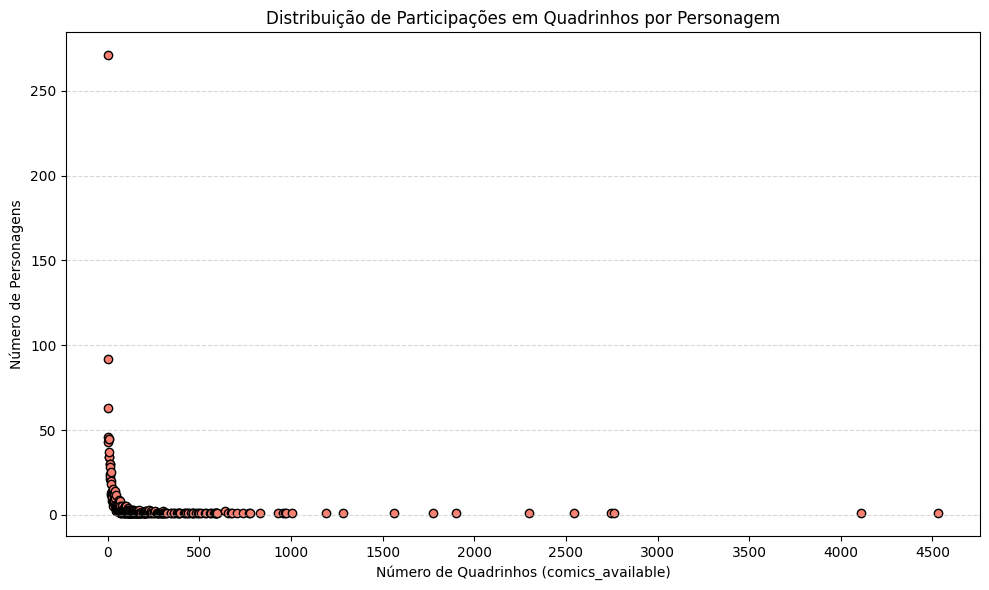

In [ ]:
conn = sqlite3.connect('marvel.db')
df_char = pd.read_sql('SELECT * FROM characters', con=conn)
df_char['comics_available'] = pd.to_numeric(df_char['comics_available'], errors='coerce')
df_counts = df_char['comics_available'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.scatter(df_counts.index, df_counts.values, color='salmon', edgecolor='black')
plt.title('Distribuição de Participações em Quadrinhos por Personagem')
plt.xlabel('Número de Quadrinhos (comics_available)')
plt.ylabel('Número de Personagens')
step = 500
x_max = df_counts.index.max()
plt.xticks(range(0, int(x_max)+1, step))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
conn = sqlite3.connect('marvel.db')
df_char = pd.read_sql('SELECT * FROM characters', con=conn)
df_char['comics_available'] = pd.to_numeric(df_char['comics_available'], errors='coerce')
df_char['modified'] = pd.to_datetime(df_char['modified'], errors='coerce')
df_plot = df_char.dropna(subset=['comics_available', 'modified', 'name']).copy()

bins = [0, 10, 50, 100, 500, 1000, 2000, 3000, 4000,float('inf')]
labels = ['0–10', '11–50', '51–100', '101–500', '501-1000','1001-2000','2001-3000','3001-4000','4000+']
df_plot['faixa_comics'] = pd.cut(df_plot['comics_available'], bins=bins, labels=labels, include_lowest=True)

df_plot['ano_mod'] = df_plot['modified'].dt.year.astype(str)

fig = px.scatter(
    df_plot,
    x='comics_available',
    y='modified',
    color='faixa_comics',
    hover_name='name',
    labels={
        'comics_available': 'Número de Quadrinhos',
        'modified': 'Data de Modificação',
        'faixa_comics': 'Faixa de Participações'
    },
    title='Participações em Quadrinhos vs. Última Modificação (por Personagem)',
    category_orders={"faixa_comics": labels}
)
fig.update_traces(marker=dict(size=7, line=dict(width=1, color='black')))
fig.update_layout(width=1000, height=600)

anos_unicos = sorted(df_plot['ano_mod'].unique())


fig.show()


In [ ]:
conn = sqlite3.connect('marvel.db')
df_char = pd.read_sql('SELECT * FROM characters', con=conn)
df_char['comics_available'] = pd.to_numeric(df_char['comics_available'], errors='coerce')
df_char['modified'] = pd.to_datetime(df_char['modified'], errors='coerce')
df_plot = df_char.dropna(subset=['comics_available', 'modified', 'name']).copy()
bins = [0, 10, 50, 100, 500, 1000, 2000, 3000, 4000,float('inf')]
labels = ['0–10', '11–50', '51–100', '101–500', '501-1000','1001-2000','2001-3000','3001-4000','4000+']
cores = {
    '0–10': 'lightgray',
    '11–50': 'lightskyblue',
    '51–100': 'dodgerblue',
    '101–500': 'seagreen',
    '501-1000': 'crimson',
    '1001-2000':'indigo',
    '2001-3000':'gold',
    '3001-4000':'darkturquoise',
    '4000+':'darkblue'
}
df_plot['faixa_comics'] = pd.cut(df_plot['comics_available'], bins=bins, labels=labels, include_lowest=True)
df_plot['cor_faixa'] = df_plot['faixa_comics'].map(cores)
df_plot['ano_mod'] = df_plot['modified'].dt.year
anos_unicos = sorted(df_plot['ano_mod'].dropna().unique())
fig = go.Figure()
for ano in anos_unicos:
    df_ano = df_plot[df_plot['ano_mod'] == ano]
    fig.add_trace(go.Scatter(
        x=df_ano['comics_available'],
        y=df_ano['modified'],
        mode='markers',
        marker=dict(size=7, color=df_ano['cor_faixa'], line=dict(width=1, color='black')),
        name=str(ano),
        text=df_ano['name'],
        hovertemplate='<b>%{text}</b><br>Quadrinhos: %{x}<br>Modificado: %{y|%Y-%m-%d}<extra></extra>',
        visible=True if ano == anos_unicos[0] else False
    ))
buttons = [
    dict(
        label="Todos os anos",
        method="update",
        args=[{"visible": [True] * len(anos_unicos)},
              {"title": "Todos os Anos"}]
    )
]
for i, ano in enumerate(anos_unicos):
    vis = [False] * len(anos_unicos)
    vis[i] = True
    buttons.append(
        dict(
            label=str(ano),
            method="update",
            args=[{"visible": vis},
                  {"title": f"Personagens modificados em {ano}"}]
        )
    )
fig.update_layout(
    title="Participações em Quadrinhos vs. Data de Modificação (com Filtro por Ano)",
    xaxis_title="Número de Quadrinhos",
    yaxis_title="Data de Modificação",
    width=1000,
    height=600,
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        buttons=buttons,
        x=1.1,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )],
    legend_title_text="Faixas de Quadrinhos"
)
fig.show()

In [ ]:
conn = sqlite3.connect('marvel.db')
df_comic_creators = pd.read_sql('SELECT * FROM comic_creators', con=conn)
df_comic_prices = pd.read_sql('SELECT * FROM comic_prices', con=conn)
df_creators = pd.read_sql('SELECT * FROM creators', con=conn)
top_creators = df_comic_creators.groupby('creator_id').size().reset_index(name='total_comics')
top_creators = top_creators.merge(df_creators, left_on='creator_id', right_on='id')
if 'fullName' not in top_creators.columns or top_creators['fullName'].isnull().all():
    top_creators['fullName'] = top_creators[['firstName', 'middleName', 'lastName', 'suffix']].fillna('').agg(' '.join, axis=1).str.strip()
top_10 = top_creators.sort_values('total_comics', ascending=False).head(10)
fig = px.bar(
    top_10,
    x='total_comics',
    y='fullName',
    orientation='h',
    color_discrete_sequence=['darkred'],
    hover_data={'total_comics': True, 'fullName': False}
)
fig.update_layout(
    title='Top 10 Criadores com Mais Participações em Quadrinhos',
    xaxis_title='Total de Quadrinhos',
    yaxis_title='Criadores',
    yaxis=dict(autorange='reversed')
)
fig.show()


In [ ]:
conn = sqlite3.connect('marvel.db')
df_creators = pd.read_sql('SELECT * FROM creators', con=conn)
top_creators = df_comic_creators.groupby('creator_id').size().reset_index(name='total_comics')
top_creators = top_creators.merge(df_creators, left_on='creator_id', right_on='id')
top_10 = top_creators.sort_values('total_comics', ascending=False).head(10)
top_10_ids = top_10['creator_id']
df_top_creators_comics = df_comic_creators[df_comic_creators['creator_id'].isin(top_10_ids)]
df_prices = df_top_creators_comics.merge(df_comic_prices, on='comic_id')
price_sum = df_prices.groupby('creator_id')['price'].sum().reset_index(name='total_price')
price_sum = price_sum.merge(df_creators, left_on='creator_id', right_on='id')
if 'fullName' not in price_sum.columns or price_sum['fullName'].isnull().all():
    price_sum['fullName'] = price_sum[['firstName', 'middleName', 'lastName', 'suffix']].fillna('').agg(' '.join, axis=1).str.strip()
price_sum = price_sum.sort_values('total_price', ascending=False)
fig = px.bar(
    price_sum,
    x='total_price',
    y='fullName',
    orientation='h',
    color_discrete_sequence=['darkred'],
    hover_data={'total_price': True, 'fullName': False}
)
fig.update_layout(
    title='Top 10 Criadores com Maior Valor Agregado em Quadrinhos',
    xaxis_title='Soma dos Preços (USD)',
    yaxis_title='Criadores',
    yaxis=dict(autorange='reversed')
)
fig.show()

In [ ]:
conn = sqlite3.connect('marvel.db')
df_comics = pd.read_sql('SELECT * FROM comics', con=conn)
df_creator_comics = df_comic_creators[df_comic_creators['creator_id'].isin(top_10_ids)]
df_comics_renamed = df_comics[['id', 'page_count']].rename(columns={'id': 'comic_id'})
df_creator_pages = df_creator_comics.merge(df_comics_renamed, on='comic_id')
df_pages_sum = df_creator_pages.groupby('creator_id')['page_count'].sum().reset_index(name='total_pages')
df_pages_sum = df_pages_sum.merge(df_creators, left_on='creator_id', right_on='id')
if 'fullName' not in df_pages_sum.columns or df_pages_sum['fullName'].isnull().all():
    df_pages_sum['fullName'] = df_pages_sum[['firstName', 'middleName', 'lastName', 'suffix']].fillna('').agg(' '.join, axis=1).str.strip()
df_pages_sum = df_pages_sum.sort_values('total_pages', ascending=False)
fig = px.bar(
    df_pages_sum,
    x='total_pages',
    y='fullName',
    orientation='h',
    color_discrete_sequence=['darkred'],
    hover_data={'total_pages': True, 'fullName': False}
)
fig.update_layout(
    title='Top 10 Criadores com Maior Total de Páginas em Quadrinhos',
    xaxis_title='Total de Páginas',
    yaxis_title='Criadores',
    yaxis=dict(autorange='reversed')
)
fig.show()